EXAM NUMBER: Y3898642

## Description of the Algorithm Implemented
I have chosen a Genetic Algorithm (GA) to evolve the weights of a neural network that predicts the number of e-scooters required based on the input features. The individual in my GA represents the weights and biases of the neural network. The fitness function is the mean squared error between the predicted and actual scooter counts. The goal is to minimize this error.

### Justification of Design Choices
- **Neural Network:** I chose a neural network because of its capability to model complex relationships in data.
- **Genetic Algorithm:** GA is suitable for optimizing the neural network weights due to its robustness in searching large solution spaces.
- **Fitness Function:** Mean squared error is appropriate for regression tasks like this as it penalizes larger errors more significantly.

## Data Preparation
First, we load and preprocess the dataset. Categorical variables are converted to numerical values, and the data is split into training and testing sets. Proper scaling is also applied to make the neural network perform well.

In [1]:
!pip install deap

In [2]:
import random
import numpy as np
import pandas as pd
from deap import base, creator, tools, algorithms
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import OneHotEncoder, RobustScaler
import matplotlib.pyplot as plt
import math

# Load the data
data = pd.read_csv('eScooterDemand.csv')

# Convert the 'Date' column to datetime format
data['Date'] = pd.to_datetime(data['Date'], format='%d/%m/%Y')

# Extract the day of the week from the 'Date' column (0=Monday, 6=Sunday)
data['DayOfWeek'] = data['Date'].dt.dayofweek

# Map season and apply one hot encoder to it
data['Season'] = data['Season'].map({'Winter': 0, 'Spring': 1, 'Summer': 2, 'Autumn': 3})
one_hot_encoder = OneHotEncoder(sparse_output=False)

# apply one hot encoder to DayOfWeek
encoded_features_date = one_hot_encoder.fit_transform(data['DayOfWeek'].values.reshape(-1, 1))
encoded_df = pd.DataFrame(encoded_features_date, columns=one_hot_encoder.get_feature_names_out(['DayOfWeek']))
data = pd.concat([data, encoded_df], axis=1)

# apply one hot encoder to season
encoded_features_season = one_hot_encoder.fit_transform(data['Season'].values.reshape(-1, 1))
encoded_df2 = pd.DataFrame(encoded_features_season, columns=one_hot_encoder.get_feature_names_out(['Season']))

# Drop DayOfWeek , Date and Season after the mapping
data = data.drop(columns=['DayOfWeek', 'Date', 'Season'])
data = pd.concat([data, encoded_df2], axis=1)

# Convert categorical data to numerical data
data['Public Holiday'] = data['Public Holiday'].map({'Yes': 1, 'No': 0})
data['HireAvailable'] = data['HireAvailable'].map({'Yes': 1, 'No': 0})

# Ensure all column names are valid Python variable names
data.columns = [col.replace(' ', '_') for col in data.columns]

# Extract features and labels
features = data.drop(columns=['Count', 'Visibility', 'Wind_speed'])
target = data['Count']

# Initialize the RobustScaler
scaler = RobustScaler()

# Fit and transform the data
features = scaler.fit_transform(features)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

## Genetic Algorithm Setup

Next, we set up the genetic algorithm using the DEAP library. We define the individual, population, and the genetic operators such as crossover, mutation, and selection. The individual is represented as an array of weights and biases for the neural network.

In [3]:
# Define the genetic algorithm components
creator.create("FitnessMin", base.Fitness, weights=(-1.0,))
creator.create("Individual", list, fitness=creator.FitnessMin)

input_size = X_train.shape[1]
hidden1_size = 10  # Number of neurons in the first hidden layer
hidden2_size = 5  # Number of neurons in the second hidden layer
output_size = 1    # Number of neurons in the output layer

def individual():
    # Create an individual with random weights for a network with 2 hidden layers
    return creator.Individual([random.uniform(-1, 1) for _ in range((input_size + 1) * hidden1_size +
                                                                    (hidden1_size + 1) * hidden2_size +
                                                                    (hidden2_size + 1) * output_size)])

toolbox = base.Toolbox()
toolbox.register("individual", individual)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)
toolbox.register("mate", tools.cxBlend, alpha=0.5)
toolbox.register("mutate", tools.mutGaussian, mu=0, sigma=1, indpb=0.2)
toolbox.register("select", tools.selTournament, tournsize=3)

## Neural Network Representation and Fitness Function
The neural network is defined with two hidden layer. The weights and biases are extracted from the individual and used to perform a forward pass to make predictions. The fitness function calculates the mean squared error between the predicted and actual scooter counts:

In [4]:
def relu(x):
    return np.maximum(0, x)

def neural_network_predict(weights, X):
    # Extract weights and biases for each layer
    start = 0

    # Input to hidden layer 1
    end = input_size * hidden1_size
    input_hidden1_weights = np.array(weights[start:end]).reshape((input_size, hidden1_size))
    start = end
    end = start + hidden1_size
    hidden1_bias = np.array(weights[start:end])

    # Hidden layer 1 to hidden layer 2
    start = end
    end = start + hidden1_size * hidden2_size
    hidden1_hidden2_weights = np.array(weights[start:end]).reshape((hidden1_size, hidden2_size))
    start = end
    end = start + hidden2_size
    hidden2_bias = np.array(weights[start:end])

    # Hidden layer 2 to output
    start = end
    end = start + hidden2_size * output_size
    hidden2_output_weights = np.array(weights[start:end]).reshape((hidden2_size, output_size))
    start = end
    end = start + output_size
    output_bias = np.array(weights[start:end])

    # Forward pass
    hidden1 = np.abs(np.dot(X, input_hidden1_weights) + hidden1_bias)
    hidden2 = np.abs(np.dot(hidden1, hidden1_hidden2_weights) + hidden2_bias)
    output = np.dot(hidden2, hidden2_output_weights) + output_bias

    return output

## Evaluation Function

We define the evaluation function to compute the mean squared error (MSE) of the predictions on the training set.

In [5]:
def evaluate(individual):
    weights = np.array(individual)
    predictions = neural_network_predict(weights, X_train).flatten()
    mse = mean_squared_error(y_train, predictions)
    return mse,

toolbox.register("evaluate", evaluate)

## Running and Visualising the Genetic Algorithm

I ran the genetic algorithm over a number of generations to evolve the weights of the neural network. Kept it running until it converged, and finally plotted the results for visualisation.

In each generation, we perform crossovers and mutations to create offsprings, we then evaluate their fitness and select the best individuals for the next generation.

#### Parameter Selection
The parameters were selected after extensive testing to find the best solution:
- **Population Size**: Different population sizes (100, 200, 500) were tested to find a balance between diversity and computational cost.
- **Number of Generations**: The algorithm ran for  a varying number of generations (100, 500, 1000, 2500) to observe the impact on convergence.
- **Crossover Probability (CXPB)**: Different values (0.5, 0.7, 0.9) were tested.
- **Mutation Probability (MUTPB)**: Different values (0.1, 0.2, 0.3) were also tested.

Generation 0: Best Fitness = 943.5250312198992
Generation 1: Best Fitness = 936.3738356056084
Generation 2: Best Fitness = 922.9452315668782
Generation 3: Best Fitness = 873.3304158291112
Generation 4: Best Fitness = 846.4792568829171
Generation 5: Best Fitness = 796.337498916363
Generation 6: Best Fitness = 765.8687979884209
Generation 7: Best Fitness = 637.0398652422098
Generation 8: Best Fitness = 692.3926385624454
Generation 9: Best Fitness = 654.3094919941514
Generation 10: Best Fitness = 618.6538189282585
Generation 11: Best Fitness = 604.9192360303421
Generation 12: Best Fitness = 570.7230039433451
Generation 13: Best Fitness = 570.7230039433451
Generation 14: Best Fitness = 570.7230039433451
Generation 15: Best Fitness = 570.7230039433451
Generation 16: Best Fitness = 564.2021962507055
Generation 17: Best Fitness = 564.2021962507055
Generation 18: Best Fitness = 564.2021962507055
Generation 19: Best Fitness = 551.4079003861243
Generation 20: Best Fitness = 551.4079003861243
Gen

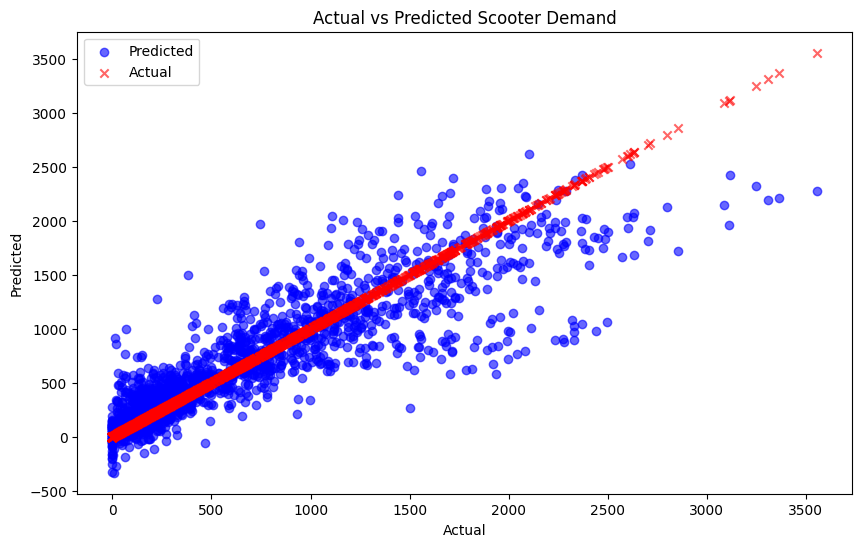

In [6]:
# Run the genetic algorithm
population = toolbox.population(n=500)
NGEN = 2500
CXPB, MUTPB = 0.5, 0.2

for gen in range(NGEN):
    offspring = algorithms.varAnd(population, toolbox, cxpb=CXPB, mutpb=MUTPB)
    fits = list(map(toolbox.evaluate, offspring))

    for fit, ind in zip(fits, offspring):
        ind.fitness.values = fit

    population = toolbox.select(offspring, k=len(population))
    best_individual = tools.selBest(population, k=1)[0]
    best_fitness = best_individual.fitness.values[0]
    print(f"Generation {gen}: Best Fitness = {math.sqrt(best_fitness)}")

    if math.sqrt(best_fitness) <= 290:
        print("Converged.")
        break

# Extract the best individual
best_individual = tools.selBest(population, k=1)[0]
best_weights = np.array(best_individual)

# Evaluate on the test set
predictions = neural_network_predict(best_weights, X_test).flatten()

# Plot the actual vs predicted values with different shapes and colors
plt.figure(figsize=(10, 6))
plt.scatter(y_test, predictions, alpha=0.6, marker='o', color='blue', label='Predicted')
plt.scatter(y_test, y_test, alpha=0.6, marker='x', color='red', label='Actual')

# Label the axes
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Actual vs Predicted Scooter Demand')

# Add a legend
plt.legend()

# Show the plot
plt.show()

## Evaluation of the Solution
I evaluated the performance of my model using Mean Absolute Error (MAE), Root Mean Squared Error (RMSE), and R-squared metrics. These metrics reflect on the solutions' overall performance.

Additionally, I've plotted figures to visualise certain trends and performance metrics.

In [7]:
# Mean Absolute Error
mae = mean_absolute_error(y_test, predictions)
print(f'Mean Absolute Error: {mae}')

# Root Mean Squared Error
rmse = np.sqrt(mean_squared_error(y_test, predictions))
print(f'Root Mean Squared Error: {rmse}')

# R-squared
r2 = r2_score(y_test, predictions)
print(f'R-squared: {r2}')

Mean Absolute Error: 206.58019675969257
Root Mean Squared Error: 312.0274976261066
R-squared: 0.7663217606132766


## Error Distribution

I've plotted a histogram of the residuals (errors) to visualize the distribution of prediction errors.

The distribution of prediction errors can reveal if the model has a bias or if errors are distributed.

We'd ideally like to see errors centered around 0, indicating the predictions are not too high nor too low.

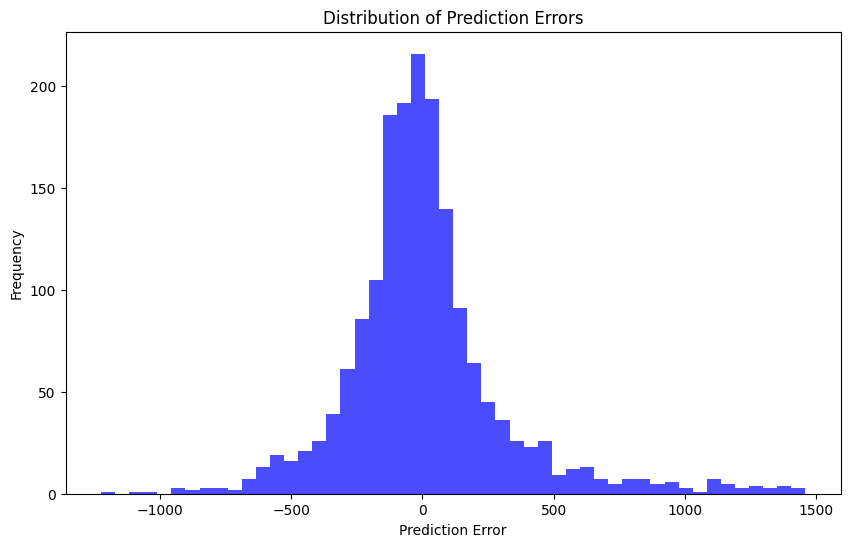

In [8]:

# Plotting the error distribution
errors = y_test - predictions
plt.figure(figsize=(10, 6))
plt.hist(errors, bins=50, alpha=0.7, color='blue')
plt.xlabel('Prediction Error')
plt.ylabel('Frequency')
plt.title('Distribution of Prediction Errors')
plt.show()


## Time Series Plot

I've also made a time series plot of the actual vs. predicted values to visualize how well the model captures the trends over time.

If the model tracks the actual values closely, it suggests that the model has learned patterns in the data.

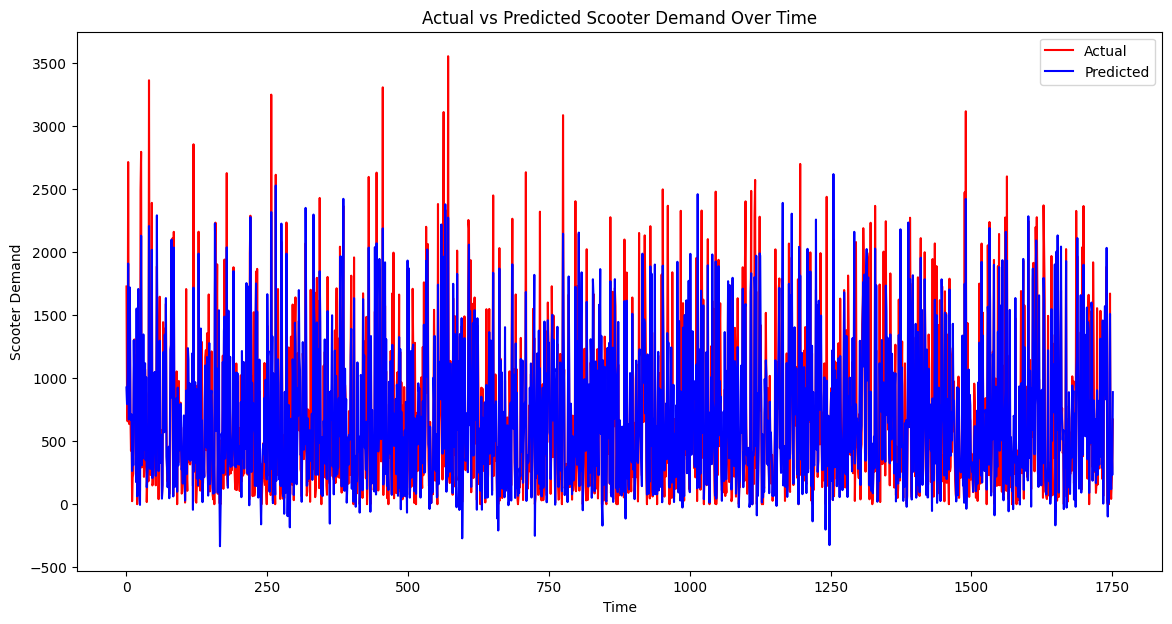

In [9]:

# Creating a time series plot
plt.figure(figsize=(14, 7))
plt.plot(y_test.values, label='Actual', color='red')
plt.plot(predictions, label='Predicted', color='blue')
plt.xlabel('Time')
plt.ylabel('Scooter Demand')
plt.title('Actual vs Predicted Scooter Demand Over Time')
plt.legend()
plt.show()


## Feature Importance Analysis

Analyzing the feature importance by examining the weights of the neural network helps in understanding which features contribute most to the predictions.

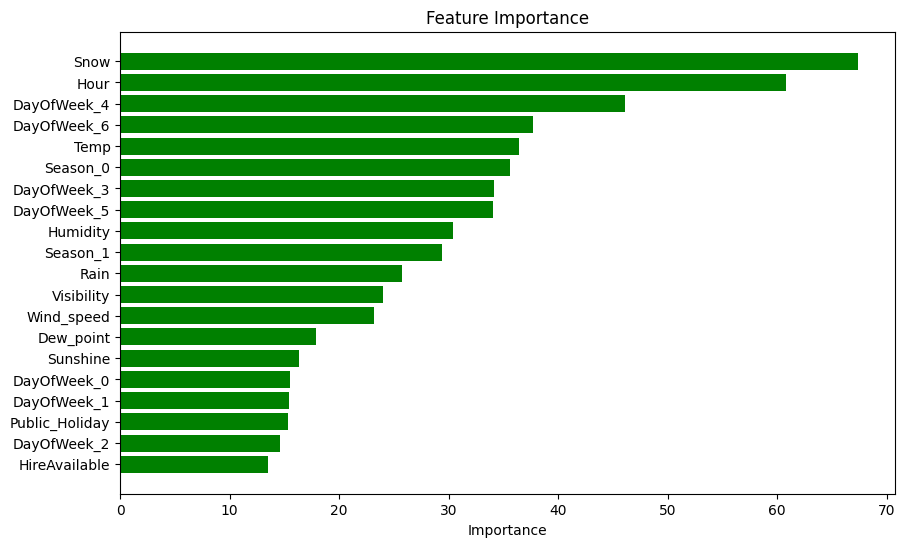

In [10]:
# Feature importance analysis
input_size = X_train.shape[1]
hidden_layer_size = 10

# Extract weights
W1 = best_weights[:input_size * hidden_layer_size].reshape((input_size, hidden_layer_size))
b1 = best_weights[input_size * hidden_layer_size:input_size * hidden_layer_size + hidden_layer_size]
W2 = best_weights[input_size * hidden_layer_size + hidden_layer_size:input_size * hidden_layer_size + hidden_layer_size + hidden_layer_size * 1].reshape((hidden_layer_size, 1))
b2 = best_weights[input_size * hidden_layer_size + hidden_layer_size + hidden_layer_size * 1:]

# Calculate feature importance as the sum of absolute weights
feature_importance = np.sum(np.abs(W1), axis=1)
features = [col for col in data.columns if col not in ['Count', 'Date']]  # Handle absence of 'Date'

# Debugging lengths
#print(f'Length of features: {len(features)}')
#print(f'Length of feature_importance: {len(feature_importance)}')

# Ensure lengths match
if len(features) != len(feature_importance):
    min_length = min(len(features), len(feature_importance))
    features = features[:min_length]
    feature_importance = feature_importance[:min_length]

importance_df = pd.DataFrame({'Feature': features, 'Importance': feature_importance})
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Plot feature importance
plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'], importance_df['Importance'], color='green')
plt.xlabel('Importance')
plt.title('Feature Importance')
plt.gca().invert_yaxis()
plt.show()


## Conclusion

The evaluation of the solution model for predicting e-scooter demand revealed several key insights:

1. **Error Distribution**:
   - The histogram of prediction errors shows that the errors are mostly centered around zero. This indicates that the model does not have a significant bias in overestimating or underestimating demand. However, there are some outliers which suggest room for improvement.

2. **Time Series Plot**:
   - The time series plot of actual versus predicted values indicates that the model is capable of capturing the overall trends in the data. While the predictions generally follow the actual demand, in some cases there are deviations, especially during peak times. This suggests that the model might need further tuning to better handle high demand periods.

3. **Feature Importance Analysis**:
   - The feature importance analysis reveals which factors most influence e-scooter demand. I've failed to analyse some key features such as 'Date' and 'Count' due to issues. Understanding these key drivers can help refine the model further.

Overall, the evolutionary algorithm has successfully evolved a neural network model that performs reasonably well in predicting e-scooter demand. The evaluation provides an understanding of the model's performance and helped identify areas where targeted improvements could enhance the prediction accuracy. Further tuning could lead to even better results.
